# Systematics: Flux, G4, MCStat, Cosmics

In [1]:
%load_ext autoreload
%autoreload 2

#print all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl
from os import path, makedirs
import sys
import uproot
from tqdm import tqdm
import datetime

# local imports
sys.path.append('../../')
from analysis_village.numucc_1p0pi.selection_definitions import *
from analysis_village.numucc_1p0pi.variable_configs import VariableConfig
from analysis_village.numucc_1p0pi.utils import *
from analysis_village.numucc_1p0pi.makedf.util import *
from pyanalib.split_df_helpers import *
from pyanalib.stat_helpers import *
from pyanalib.pandas_helpers import *
from pyanalib.variable_calculator import get_cc1p0pi_tki
from pyanalib.pandas_helpers import pad_column_name
from makedf.constants import *

plt.style.use("presentation.mplstyle")
cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=0.0, vmax=1.0)
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from matplotlib.offsetbox import AnchoredOffsetbox, DrawingArea, HPacker, VPacker, TextArea
from matplotlib.legend import Legend

In [3]:
save_fig = False
today_str = datetime.datetime.now().strftime("%Y%m%d")
save_fig_dir = "/exp/sbnd/data/users/munjung/plots/numucc1p0pi/systematics-other-{}".format(today_str)
if not path.exists(save_fig_dir):
    makedirs(save_fig_dir)

In [4]:
file_dir = "/exp/sbnd/data/users/munjung/xsec/2025Spring_v10_06_00_09"

## -- MC 
mc_file = path.join(file_dir, "MC", "BNB_cosmics", "aa.df")
mc_split_df = pd.read_hdf(mc_file, key="split")
mc_n_split = get_n_split(mc_file)
print("mc_n_split: %d" %(mc_n_split))
print_keys(mc_file)

n_max_concat = 3
mc_keys2load = ['hdr', 'evt'] 
mc_dfs = load_dfs(mc_file, mc_keys2load, n_max_concat=n_max_concat)
mc_hdr_df = mc_dfs['hdr']
mc_evt_df = mc_dfs['evt']

mc_n_split: 1
Keys: ['/evt_0', '/hdr_0', '/histpotdf_0', '/split']


# MC Stat

In [5]:
def get_MCstat_unc(evt_df, hdr_df, n_universes=100):
    # Create a unique seed based on event metadata
    # Using a hash function that's deterministic
    meta_seeds = []
    for i in tqdm(range(len(evt_df))):
        this_hdr_df = hdr_df.loc[evt_df.reset_index(level=[2]).index[i]]
        runno = this_hdr_df.run
        subrunno = this_hdr_df.subrun
        evtno = this_hdr_df.evt
        slcid = mc_evt_df.loc[mc_evt_df.index[i]].slc.self
        unique_seed = hash(f"run_{runno}_subrun_{subrunno}_evt_{evtno}_slcid_{slcid}") % (2**32)  # Ensure it's a 32-bit integer
        if unique_seed in meta_seeds:
            print("duplicate seed found", unique_seed)
            break
        meta_seeds.append(unique_seed)

    # make sure the seeds are unique!
    assert len(meta_seeds) == len(set(meta_seeds))

    # generate universes
    n_universes = 100
    MCstat_univ_events = np.zeros((n_universes, len(evt_df)))
    poisson_mean = 1.0

    # get Poisson weights and save to "MCstat.univ_"
    # dummy df to hold the weights -- iterative inserting causes PerformanceWarning
    mcstat_univ_cols = pd.MultiIndex.from_product(
        [["MCstat"], [f"univ_{i}" for i in range(n_universes)], [""], [""], [""], [""], [""]],
    )
    mcstat_univ_wgt = pd.DataFrame(
        1.0,
        index=evt_df.index,
        columns=mcstat_univ_cols,
    )

    for uidx in range(n_universes):
        universe_seed = hash(f"universe_{uidx}") % (2**32)
        
        poisson_weights = []
        for sidx, meta_seed in enumerate(meta_seeds):
            # Combine universe seed with event seed for unique randomness -- per event, per universe
            combined_seed = (universe_seed + meta_seed) % (2**32)
            np.random.seed(combined_seed)
            
            poisson_val = np.random.poisson(poisson_mean)
            poisson_weights.append(poisson_val)
        
        mcstat_univ_wgt[("MCstat", "univ_{}".format(uidx), "", "", "", "", "")] = np.array(poisson_weights)
        MCstat_univ_events[uidx, :] = np.array(poisson_weights)

    evt_df = evt_df.join(mcstat_univ_wgt)
    return evt_df, MCstat_univ_events

In [6]:
mc_evt_df, MCstat_univ_events = get_MCstat_unc(mc_evt_df, mc_hdr_df, n_universes=100)

100%|██████████| 3338/3338 [00:14<00:00, 235.94it/s]


In [15]:
def get_univ_rates(evtdf, var_config, syst_name):
    var = evtdf[var_config.var_evt_reco_col]
    n_cv, _ = np.histogram(var, bins=var_config.bins)

    univ_events = []
    for uidx in range(len(mc_evt_df[syst_name].columns)):
        weights = mc_evt_df[syst_name]["univ_{}".format(uidx)]
        # fill nan (these are non-neutrino events) with 1
        weights = np.where(np.isnan(weights), 1, weights)
        n, bins = np.histogram(var, bins=var_config.bins, weights=weights)
        univ_events.append(n)
    univ_events = np.array(univ_events)
    return univ_events, n_cv


In [8]:
def plot_univ_hist(evtdf, var_config, syst_name, univ_events, n_cv):
    n_univ = len(evtdf[syst_name].columns)
    if (n_univ > 10):
        colors = ["C0", "C1", "C2"]

        sorted_univs = np.sort(univ_events, axis=0)

        n_68 = int(0.68 * n_univ)
        start_68 = (n_univ - n_68) // 2
        end_68 = start_68 + n_68

        n_95 = int(0.95 * n_univ)
        start_95 = (n_univ - n_95) // 2
        end_95 = start_95 + n_95

        # Define bins & groupings for easy handling: [(range, color, label, skip_68)]
        segs = [
            (range(start_68, end_68), colors[0], "Universe (68%)", False),
            (range(start_95, end_95), colors[1], "Universe (95%)", True),
            ( (i for i in range(n_univ) if i not in range(start_95, end_95)), colors[2], "Universe (100%)", False)
        ]

        plotted = set()  # tracks which labels were plotted already
        for r, color, label, skip_68 in segs:
            for i in r:
                if skip_68 and i in range(start_68, end_68): 
                    continue
                show_label = label if label not in plotted else None
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=sorted_univs[i],
                        histtype="step", color=color, alpha=0.7, label=show_label)
                plotted.add(label)

    # if too few universes, just plot all of them in gray
    else:
        for i in range(n_univ):
            if i == 0:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=univ_events[i], histtype="step", color="gray", label="Universe")
            else:
                plt.hist(var_config.bin_centers, bins=var_config.bins, weights=univ_events[i], histtype="step", color="gray")

    # CV universe
    plt.hist(var_config.bin_centers, bins=var_config.bins, weights=n_cv, histtype="step", color="k", label="Central Value")

    plt.xlim(var_config.bins[0], var_config.bins[-1])
    plt.xlabel(var_config.var_labels[1])
    plt.ylabel("Events / Bin")
    plt.title(syst_name)

    # plt.text(0.05, 0.05, "SBND Internal", fontsize=12, color="rosybrown", ha="left", va="bottom", transform=ax.transAxes)
    plt.legend(reverse=True, frameon=False)
    plt.show();


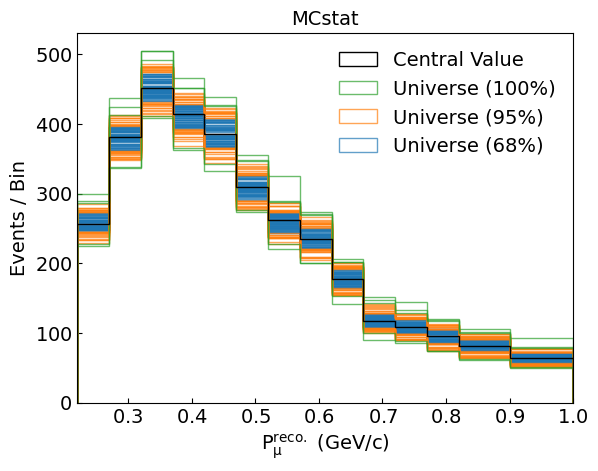

In [10]:
syst_name = "MCstat"

var_config = VariableConfig.muon_momentum()

univ_events, n_cv = get_univ_rates(mc_evt_df, var_config,syst_name)
plot_univ_hist(mc_evt_df, var_config, syst_name, univ_events, n_cv)

# Flux

/tmp/ipykernel_3683503/2069898625.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  for uidx in range(len(mc_evt_df[syst_name].columns)):
/tmp/ipykernel_3683503/2069898625.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  weights = mc_evt_df[syst_name]["univ_{}".format(uidx)]
/tmp/ipykernel_3683503/3398999335.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  n_univ = len(evtdf[syst_name].columns)


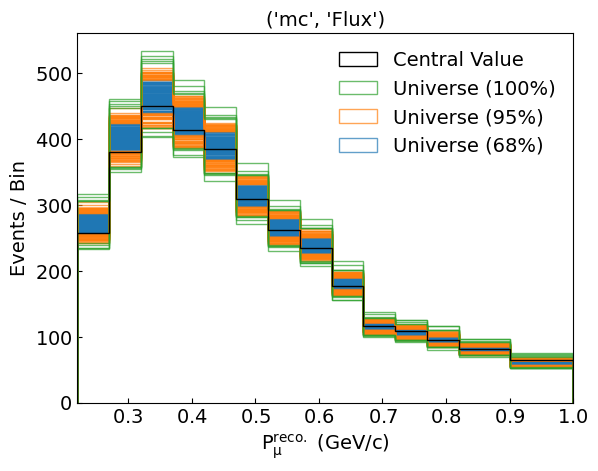

In [16]:
syst_name = ("mc", "Flux")

var_config = VariableConfig.muon_momentum()

univ_events, n_cv = get_univ_rates(mc_evt_df, var_config, syst_name)
plot_univ_hist(mc_evt_df, var_config, syst_name, univ_events, n_cv)

# G4

/tmp/ipykernel_3683503/2069898625.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  for uidx in range(len(mc_evt_df[syst_name].columns)):
/tmp/ipykernel_3683503/2069898625.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  weights = mc_evt_df[syst_name]["univ_{}".format(uidx)]
/tmp/ipykernel_3683503/3398999335.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  n_univ = len(evtdf[syst_name].columns)


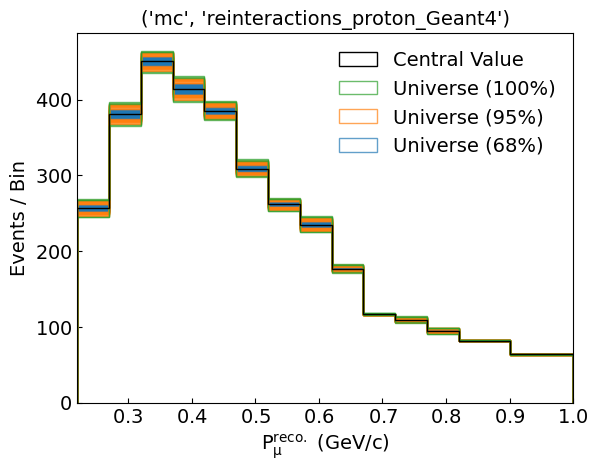

In [20]:
syst_name = ("mc", "reinteractions_proton_Geant4")
# syst_name = ("mc", "g4")

var_config = VariableConfig.muon_momentum()

univ_events, n_cv = get_univ_rates(mc_evt_df, var_config, syst_name)
plot_univ_hist(mc_evt_df, var_config, syst_name, univ_events, n_cv)